# Word Embeddings

### Jay Dhanoa & Andy Ham (aham-jdhanoa)

In [1]:
import re
import operator
import math
import string
import nltk
import cPickle
import time
import scipy
import cPickle
import numpy as np
from scipy import sparse
from operator import add
from scipy import sparse
from pyspark.sql import SparkSession
from collections import Counter
from pprint import pprint

def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and punctuation to whitespace
    s = s.encode('utf-8').lower().replace('-',' ').translate(None, string.punctuation)
    # replace \r\n
    s = re.sub(r'(\r\n )+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    return s.split(' ')

stopwords = set(nltk.corpus.stopwords.words('english'))
freq_cutoff = 420
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]

num_chunks = 560
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]

# spark  = SparkSession.builder.config("spark.driver.maxResultSize", "20g").config("spark.executor.memory","4g").master('local[200]').appName('word_embeddings')\
# .getOrCreate()

spark  = SparkSession.builder.config("spark.driver.maxResultSize", "20g")\
.master('local[28]').appName('word_embeddings').getOrCreate()

wiki_data = spark.sparkContext.parallelize(wiki_chunks)
parsed_wiki = wiki_data.map(lambda x: clean_and_split(x))
word_vec = parsed_wiki.flatMap(lambda x: x).filter(lambda x: x!='').repartition(num_chunks).glom()
wordcount = parsed_wiki.flatMap(lambda x: x).map(lambda x: (x,1)).reduceByKey(lambda x, y: x+y)
to_del = wordcount.filter(lambda x: x[1]<freq_cutoff).map(lambda x: x[0]).collect()

wordcount = wordcount.filter(lambda x: x[1] >=freq_cutoff).sortBy(lambda x: x[1], ascending=False)\
.filter(lambda x: x[0] not in stopwords)

vocab = wordcount.map(lambda x: x[0]).sortBy(lambda x: x)
wc = wordcount.take(50)

with open('p2vocab','r') as fh:
    vocabulary = cPickle.load(fh)

d = len(vocabulary)

D = 50579001 # number of unique (word, context) pairs with a window size of 5

vocab_size = 14877 # with 420 occurrences or more, stopwords removed

vocabset = set(vocabulary)

enum_dict = {}
for i, word in enumerate(vocabulary):
    enum_dict[word] = i
    
print("{} words in vocabulary".format(d))
print("\nTOP 50 WORDS (word, frequency):\n")
for i, (key, val) in enumerate(wc):
    print("{}: {}, {}".format(i+1, key, val))


14877 words in vocabulary

TOP 50 WORDS (word, frequency):

1: one, 3776766
2: zero, 3085167
3: two, 2339798
4: nine, 2063643
5: eight, 1489527
6: three, 1483143
7: four, 1459619
8: five, 1456360
9: six, 1283961
10: seven, 1123112
11: age, 281525
12: also, 274359
13: population, 251315
14: years, 196050
15: km, 191331
16: new, 183024
17: city, 183019
18: first, 178329
19: american, 172338
20: county, 171871
21: mi, 166361
22: living, 166189
23: income, 150360
24: median, 146172
25: total, 140499
26: united, 131493
27: many, 129520
28: states, 128607
29: people, 127707
30: time, 124548
31: census, 123692
32: used, 121418
33: may, 120710
34: town, 118591
35: average, 118513
36: see, 117755
37: older, 116742
38: area, 116077
39: families, 115631
40: family, 112110
41: males, 112003
42: females, 111417
43: households, 110154
44: line, 109212
45: made, 108321
46: world, 103350
47: would, 99604
48: every, 96913
49: war, 91303
50: external, 91053


These new word frequencies aren't really surprising. Wikipedia generally follows good editing/grammar practices, one of which is that usually any number less than 10 is fully written out, and since we'd expect these words to appear relatively independent of context, we should be expecting these values to appear somewhat often.

In [2]:
window_size = 5

def generate_word_context_pairs(word_vec):
    results = []
    for i in range(len(word_vec)):
        word = word_vec[i]
        iter_args = map(lambda x: x+1, range(window_size))
        for j in iter_args:
            if i-j>=0:
                if word in vocabset and word_vec[i-j] in vocabset:
                    results.append((word, word_vec[i-j]))
            if i+j<=len(word_vec)-1:
                if word in vocabset and word_vec[i+j] in vocabset:
                    results.append((word, word_vec[i+j]))
    return results

def gen_row(x):
    w_i, ct = x
    w_i_ct = context_vec[enum_dict[w_i]]
    result = map(lambda w_j: (ct[w_j], context_vec[enum_dict[w_j]]), vocabulary)
    # pairs are (#(w_i, w_j), #(w_j))
    result = map(lambda x: np.log((float(x[0]+1)*50579001)/(w_i_ct*x[1])), result)
    matrix = sparse.lil_matrix((d,d))
    matrix[enum_dict[w_i]]=result
    return matrix

def generate_matrix():
    ct = word_vec.map(lambda x: generate_word_context_pairs(x)).flatMap(lambda x: x).map(lambda x: (x,1))\
    .reduceByKey(lambda x, y: x+y)

    unique_pairs = ct.count()

    context_vec = ct.map(lambda x: (x[0][0],x[1])).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[0])\
    .map(lambda x: x[1]).collect()

    rows = ct.map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(list)\
    .map(lambda x: (x[0], Counter(dict(x[1]))))

    final_matrix = rows.map(lambda x: gen_row(x)).reduce(lambda x, y: x+y)
    with open('sparselilmatrix','w') as fh:
        cPickle.dump(final_matrix,fh)
    with open('rowexample','w') as fh:
        cPickle.dump(rows.take(1),fh)
    with open('contextvec','w') as fh:
        cPickle.dump(context_vec,fh)

Just to briefly walk through the code above:
* `generate_word_context_pairs` accepts a list of strings (words), and returns every (word, context) pair within the appropriate window size (`window_size`)
* `generate_matrix` was the series of commands that we used to generate the matrix $M$. I initially used lil_matrix (due to some confusion over sparse_csr_matrix's ability to support assignment), which supposedly takes a long time to add, but it only took about 10-15 mins to perform the final reduce step for final_matrix.
    * ct was a list of (($w_i, w_j$),count) tuples, which counted the number of times a word-context pair appeared in the corpus
    * context_vec contains, in correspondence to each $w_i$ in our sorted vocabulary vector, the number of times that vector appeared in the corpus
    * rows contains ($w_i$, Counter) pairs. The Counter object is a mapping from each $w_j$ that appears as a context for $w_i$ to the number of times that $w_j$ appears as a context for $w_i$ (in essence, the Counter is storing the co-occurrence data). Conveniently, for any object that Counter hasn't kept track of, it returns 0.
* `gen_row` accepted one of the ($w_i$, Counter) pairs from rows in `generate_matrix`, and returned a sparse matrix of size $dxd$, where $d$ is the size of our vocabulary. The sparse matrix was only filled in for the row corresponding to $w_i$. The row was filled with the rows of $m$.

Loading in our new vectors:

In [3]:
def decompose():
    with open('sparselilmatrix','r') as fh:
        M = cPickle.load(fh)
    U, s, V = scipy.sparse.linalg.svds(M,k=50)
    S = np.diag(s) # s is 1-dimensional, we want it to be a diagonal matrix
    sigsqrt = np.sqrt(S)
    embeddings = np.dot(U,sigsqrt)
    with open('p2embeddings','w') as fh:
        cPickle.dump(embeddings,fh)

with open('p2embeddings','r') as fh:
    embeddings = cPickle.load(fh)
evecs = {}
for i, word in enumerate(vocabulary):
    evecs[word] = embeddings[i]

# glove vocabulary
with open('wiki-vocab.txt','r') as fh:
    words = [x.rstrip().split(' ')[0] for x in fh.readlines()]

glovset = set(words)

# glove 
with open('wiki-vectors.txt','r') as fh:
    local_vectors = {}
    for line in fh:
        vals = line.rstrip().split(' ')
        local_vectors[vals[0]] = np.array([float(x) for x in vals[1:]])

with open('glove.6B.50d.txt','r') as fh:
    pretrained_vectors = {}
    for line in fh:
        vals = line.rstrip().split(' ')
        pretrained_vectors[vals[0]] = np.array([float(x) for x in vals[1:]])

vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

The `decompose` function contains the code for SVD-ing our large matrix M. While loading it in from disk did take a while (understandable, given that $M$ was a whopping 7.7 GB), truncated SVD only took ~2.5 minutes.

## Word Similarity

In [4]:
def most_similar_word(input_val, vector_dict, topn=5, input_is_vector=False):
    result = []
    if input_is_vector:
        input_vector = input_val
    else:
        input_vector = vector_dict[input_val]
    list_of_keys = vector_dict.keys()
    result = [(i, np.linalg.norm(input_vector-vector_dict[i])) for i in list_of_keys]
    result = sorted(result, key=lambda x: x[1])
    return result[1:topn+1]


test_words = ['physics','republican','einstein','algebra','fish']

for word in test_words:
    my_results = most_similar_word(word, evecs)
    local_results = most_similar_word(word, local_vectors)
    pretrained_results = most_similar_word(word, pretrained_vectors)
    
    print("Top 5 words for: {}\n".format(word))
    print("{:<4}{:<20}{:<20}{:<20}".format("","Generated","GloVe local", "GloVe pretrained"))
    print("-"*64)
    for i, (word, distance) in enumerate(my_results):
        print("{:<4}{:<20}{:<20}{:<20}".format(str(i+1)+":",word,local_results[i][0],pretrained_results[i][0]))
    print("\n")

Top 5 words for: physics

    Generated           GloVe local         GloVe pretrained    
----------------------------------------------------------------
1:  mechanics           chemistry           chemistry           
2:  chemistry           mathematics         mathematics         
3:  quantum             mechanics           theoretical         
4:  mathematics         theoretical         science             
5:  sciences            science             biology             


Top 5 words for: republican

    Generated           GloVe local         GloVe pretrained    
----------------------------------------------------------------
1:  senator             democrat            gop                 
2:  democrat            senator             democrat            
3:  representative      representative      democratic          
4:  presidential        democrats           republicans         
5:  candidate           whig                democrats           


Top 5 words for: einstein

    

For the most part, the results are pretty similar, with the top 5 for every word having at least one word in common across all three columns. I suspect that some of the differences may be accounted for by virtue of GloVe's larger vocabulary size (~3x the size we're using for this exercise).

Notable features w.r.t. invdividual words:
* Einstein: The keywords are all either related to relativity, were well-known physicists (e.g. Maxwell, Klein, Gottlieb), or were contemporaries of Einstein (Freud, Klein, Gottlieb sort of).
* Fish: For our generated columns, fish appears to be mostly used in the sense of food groups or in association with generic features of nature. The GloVe pretrained/local models, on the other hand, have more specific words relating to fish. This difference isn't accounted for by the differences in vocabulary size, given that every word in the three columns for fish is in our 15k word vocabulary.

## Analogies

Loading in the data:

In [5]:
import os
root, folders, files = next(os.walk('/project/cmsc25025/assn4_analogy'))
analogies= []
for filename in files:
    with open(os.path.join(root,filename),'r') as fh:
        text = fh.read()
        for match in re.finditer(r'([A-Za-z]+)\:([A-Za-z]+)\=([A-Za-z]+)\:\?',
                                 text):
            analogies.append((match.group(1),match.group(2),match.group(3)))

Each analogy took ~1-2s to generate. For larger-scale calculation of analogies or data, RDD maps are generally the way to go. Most of the time the RDD took was actually to distribute the corresponding vector matrix to each worker task.

In [6]:
def solve_analogy(analogy, vector_dict):
    key_1, key_2, key_a = analogy
    word_loc = vector_dict[key_2]-vector_dict[key_1]+vector_dict[key_a]
    return most_similar_word(word_loc, vector_dict, topn=1, input_is_vector=True)[0]

discarded_analogies = []

for analogy in analogies:
    k1, k2, ka = analogy
    if k1 not in glovset or k1 not in vocabset:
        discarded_analogies.append(analogy)
        continue
    if k2 not in glovset or k2 not in vocabset:
        discarded_analogies.append(analogy)
        continue
    if ka not in glovset or ka not in vocabset:
        discarded_analogies.append(analogy)
        continue

selected_analogies = [analogy for analogy in analogies if analogy not in discarded_analogies]

analogy_rdd = spark.sparkContext.parallelize(selected_analogies)

my_result = analogy_rdd.map(lambda x: solve_analogy(x, evecs)).collect()
local_result = analogy_rdd.map(lambda x: solve_analogy(x, local_vectors)).collect()
pretrained_result = analogy_rdd.map(lambda x: solve_analogy(x, pretrained_vectors)).collect()

for i in range(len(my_result)):
    k1, k2, ka = selected_analogies[i]
    analogy_str = "{}:{}={}:?".format(k1,k2,ka)
    print("{}\n".format(analogy_str))
    print("{:<20}{:<20}{:<20}".format("Generated","GloVe local", "GloVe pretrained"))
    print("-"*60)
    print("{:<20}{:<20}{:<20}".format(my_result[i][0],local_result[i][0],pretrained_result[i][0]))
    print("\n")

argentina:brazil=iran:?

Generated           GloVe local         GloVe pretrained    
------------------------------------------------------------
pakistan            turkey              tehran              


telephone:cord=television:?

Generated           GloVe local         GloVe pretrained    
------------------------------------------------------------
animated            cast                spinal              


chinese:china=french:?

Generated           GloVe local         GloVe pretrained    
------------------------------------------------------------
french              french              french              


evening:morning=dinner:?

Generated           GloVe local         GloVe pretrained    
------------------------------------------------------------
dinner              lunch               lunch               


left:right=horizontal:?

Generated           GloVe local         GloVe pretrained    
------------------------------------------------------------
vertical 

For the most part, our model yields words that are conceptually close to the ones yielded by GloVe, both pretrained and trained. Some of the more basic analogies (e.g. left:right=horizontal:vertical) match across all three.

Some of the more complex analogies (e.g. Chicago:Illinois=Dallas:iowa/iowa/illinois) didn't yield a correct answer across any of the models. In fairness to the model, though, some of the analogies are a bit ambiguous, even for people (e.g. detroit:chicago=car:?). 

The models seemed to be relatively hit or miss with more associative analogies (e.g. china:tea=france:wine working, but pork:pig=beef:? failing for all three models).

I was pleased to see that there was at least one instance in which our model got correct an association that GloVe didn't (wolf:dog=tiger:?), with our model yielding cat, and the local/pretrained models yielding tiger/dog, respectively.

Some interesting analogies (of the format: a:b=c:our_model/glove_local/glove_pretrain):
* pen:sword=love:man/soul/sword - I guess love is as mighty, if not mightier, than the pen.
* dictionary:definition=novel:story/sequel/effect
* germany:hitler=china:taiwan/zedong/jiang - GloVe local correctly identified Mao Zedong, which would have been my guess. Jiang is presumably a reference to Jiang Zemin, General Secretary of the Communist Party of China until 2002.
* america:burger=italy:parma/blois/unicredito - Our model was able to get a relatively correct answer here, with Parma presumably being a reference to Chicken Parmesan.
* north:south=east:south/south/south - The only explanation I can think of is that north/east/south/west are clustered relatively close together, and since they wouldn't be used often as antonyms (in the same way that happy:sad might be), all three models chose south as the closest neighbor.
* chef:knife=student:students/students/*gun* - I can only guess that all the weapons are relatively close together.
* There are multiple chicago:illinois=texas_city:? analogies, which the models keep answering with midwestern states.


The following analogies were discarded for containing words outside either GloVe's vocabulary (~46k words), or our vocabulary (~15k words).

In [7]:
for analogy in discarded_analogies:
    k1, k2, ka = analogy
    print("{}:{}={}:?".format(k1,k2,ka))

segregate:unify=damage:?
ashes:urn=money:?
walk:roam=speak:?
novel:epilogue=meal:?
theorem:deduce=hypothesis:?
library:book=resturant:?
dessert:meal=revelations:?
thor:loki=hammer:?
odin:hela=asgard:?
beijing:shanghai=tiananmen:?
lannister:stark=tywin:?
uchicago:northwestern=smart:?
healthy:vegetable=unhealthy:?
left:right=up:?
dog:cat=puppy:?
day:night=up:?
hard:easy=awake:?
japan:sushi=mexico:?
cat:kitten=dog:?
knight:squire=professor:?
coffee:milk=toast:?
picture:blurry=knife:?
drizzle:storm=wind:?
michigan:lansing=illinois:?
hammer:nail=screwdriver:?
tennis:racket=baseball:?
Illinois:Springfield=Connecticut:?
mango:fruit=eggplant:?
pen:write=scissor:?
snake:reptile=frog:?
up:down=left:?
compactness:topology=differentiability:?
filibuster:holdup=gerrymandering:?
miserly:generous=languid:?
happiness:ecstasy=unhappiness:?
excitement:quench=fire:?
proletariet:bourgeois=man:?
baby:adult=puppy:?
novice:master=amateur:?
short:tall=skinny:?
thank:apologize=greet:?
russia:putin=germany:?
fe

### T-SNE visualization of pretrained GloVe embeddings

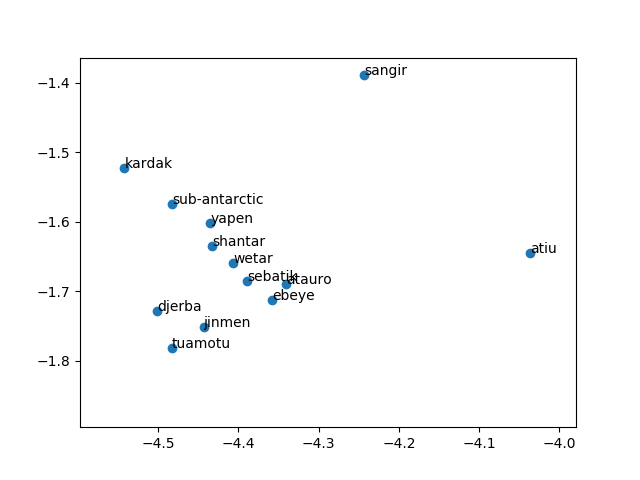

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
import sys

def plot_glove():
    reload(sys)
    sys.setdefaultencoding('utf8')
    #W contains embeding vectors as rows
    # words contains the word labels in the same order as the rows of W

    W_words = pretrained_vectors.keys()
    W = pretrained_vectors.values() 

    tsne = TSNE(n_components=2, random_state = 0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(W[:5000])

    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(W_words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext = (0, 0),
            textcoords='offset points')

    plt.show()
    
from IPython.display import Image
Image(filename='isles.png')

Final window: X: [-4.8, -4.0], Y: [-1.2, -1.9]

For the above cluster of words, we find (mostly) words describing small islands:
* Sangir is the largest island of the Sangihe islands, a group of islands in Northern Indonesia
* Kardak is a pair of small islands in the Aegean sea
* Shantar is the name of a small group of 15 islands off the coast of Russia
* Wetar is a small island in the Indonesian province of Maluku
* Djerba is a small island off the coast of Tunisia
* Jinmen, meaning *golden gate* in Chinese, is the name of a group of islands off the southeastern coast of China
* Tuamotu(s) are a chain of ~80 islands/atolls in French Polynesia
* Atiu is a small island in the Southern Islands group of the Cook Islands Archipelago
* Ebeye is the most populous island of the Kwajalein Atoll in the Marshall Islands
* Atauro is a small island in Indonesia. Its name literally translates to 'goat island,' in reference to the large number of goats that inhabit the island

Some stuff that's a little out of place:
* Vapen is swedish for 'weapon,' and is also apparently colloquially a term for marijuana use via an e-cig/vaporizer.
* Sub-antarctic isn't *quite* as out of place, since it's still on the topic of geography